# Jax-Bayes MNIST Example --- Bayesian Variational Inference Approach
To run on Colab, just run the cells sequentially
## Setup the Environment

In [1]:
#see https://github.com/google/jax#pip-installation
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.51-cp36-none-manylinux2010_x86_64.whl
!pip install --upgrade jax
!pip install git+https://github.com/deepmind/dm-haiku
#you may have to retart your runtime and re-run this cell due to dependency 
# conflict with pre-installed tensorflow.
!pip install git+https://github.com/jamesvuc/jax-bayes

  Using cached https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.51-cp36-none-manylinux2010_x86_64.whl
  Found existing installation: jaxlib 0.1.51
    Uninstalling jaxlib-0.1.51:
      Successfully uninstalled jaxlib-0.1.51
Requirement already up-to-date: jax in /usr/local/lib/python3.6/dist-packages (0.1.75)
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-_ccvuft_
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-_ccvuft_
  Created wheel for dm-haiku: filename=dm_haiku-0.0.2-cp36-none-any.whl size=289647 sha256=f50e41fcc24e1e1ec2820018713af4b8dbf91e2567fd91e99d6382fac5b0a401
  Stored in directory: /tmp/pip-ephem-wheel-cache-2vifbrhy/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku
  Cloning https://github.com/jamesvuc/jax-bayes to /tmp/pip-req-build-37_cznuc
  Running command git clone -q https://github.com/jamesvuc/jax-bayes /tmp/pip-req-build-37_cznuc
  Created wheel

In [2]:
import haiku as hk

import jax.numpy as jnp
from jax.experimental import optimizers
import jax

import jax_bayes

import sys, os, math, time
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow_datasets as tfds

## Loat Data and Create the Model *(same as traditional)*

In [3]:
def load_dataset(split, is_training, batch_size):
	ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
	if is_training:
		ds = ds.shuffle(10 * batch_size, seed=0)
	ds = ds.batch(batch_size)
	return tfds.as_numpy(ds)

def net_fn(batch):
	""" 
  Standard LeNet-300-100 MLP 
	"""
	x = batch["image"].astype(jnp.float32) / 255.
	mlp = hk.Sequential([
		hk.Flatten(),
		hk.Linear(300), jax.nn.relu, 
		hk.Linear(100), jax.nn.relu, 
		hk.Linear(10)])

	return mlp(x)

## Build the Optimizer, Loss, Accuracy, and ~Train Step~ VI Step

In [28]:
#hyperparameters 
# lr = 1e-3
# lr = 5e-3
lr = 1e-4
reg = 1e-4
num_samples = 25

#instantiate the model --- same as regular case
net = hk.transform(net_fn)

#build the variational family
seed = 0
key = jax.random.PRNGKey(seed)
vf = jax_bayes.variational.diagonal_mvn_fns(key, init_sigma = 0.1)

#build the optimizer
opt_init, opt_update, opt_get_params = optimizers.adam(lr)

# loss is the same as the regular case! This is because in regular ML, we're minimizing
# the negative log-posterior logP(params | data) = logP(data | params) + logP(params) + constant
# i.e. finding the MAP estimate.
def loss(params, batch):
  logits = net.apply(params, None, batch)
  labels = jax.nn.one_hot(batch['label'], 10)

  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) 
            for p in jax.tree_leaves(params))
  softmax_crossent = - jnp.mean(labels * jax.nn.log_softmax(logits))

  return softmax_crossent + reg * l2_loss

#the log-probability is the negative of the loss
logprob = lambda p,b : - loss(p, b)

@jax.jit
def accuracy(params, batch):
  # preds = net.apply(params, None, batch)
  # return jnp.mean(jnp.argmax(preds, axis=-1) == batch['label'])
  pred_fn = lambda p:net.apply(p, None, batch) 
  pred_fn = jax.vmap(pred_fn)
  pred_probs = jnp.mean(pred_fn(params), axis=0)#average out the model params
  return jnp.mean(jnp.argmax(pred_probs, axis=-1) == batch['label'])

@jax.jit
def bbvi_step(i, opt_state, var_keys, batch):
  var_params = opt_get_params(opt_state)
  logp = jax.vmap(lambda p: logprob(p, batch))

  var_keys = vf.next_key(var_keys) #generate one key to use now
  next_keys = vf.next_key(var_keys) #generate one to return

  #define the elbo estimator
  def elbo(p, keys):
    #deinfe the 'reparameterization trick' ELBO estimator
    samples_state, _ = vf.sample(0, num_samples, keys, p)
    samples = vf.get_samples(samples_state)
    return  jnp.mean(logp(samples) - vf.evaluate(samples_state, p))

  #the objective is the negative of the elbo (since optimizers minimize)
  obj = lambda p: - elbo(p, var_keys)

  #usual optimization step
  _loss, dlambda = jax.value_and_grad(obj)(var_params)
  opt_state = opt_update(i, dlambda, opt_state)
  return opt_state, _loss, next_keys

@jax.jit
def eval_step(opt_state, var_keys, batch):
  #pull out the variational params from the optimizer state
  var_params = opt_get_params(opt_state)
  
  #generate some samples
  samples_state, _ = vf.sample(0, num_samples, var_keys, var_params)
  
  #sample some parameter values
  params = vf.get_samples(samples_state)
  
  #compute the metrics
  val_acc = accuracy(params, next(val_batches))
  test_acc = accuracy(params, next(test_batches))
  return dict(val_acc=val_acc, test_acc=test_acc)

## Load Batch Iterators & Do the ~Optimization~ Sampling

In [ ]:
# load the data into memory and create batch iterators
train_batches = load_dataset("train", is_training=True, batch_size=1_000)
val_batches = load_dataset("train", is_training=False, batch_size=10_000)
test_batches = load_dataset("test", is_training=False, batch_size=10_000)

In [31]:
%%time
#get a single sample of the params using the normal hk.init(...)
params = net.init(jax.random.PRNGKey(42), next(train_batches))

#instantiate the var_params and the optimizer state (containing the var_params)
var_params, var_keys = vf.init(params)
opt_state = opt_init(var_params)

#optimize the variational parameters to maximize the ELBO
for step in range(10_001):
  opt_state, _loss, var_keys = \
    bbvi_step(step, opt_state, var_keys, next(train_batches))

  if step % 500 == 0:
    metrics = eval_step(opt_state, var_keys, next(test_batches))
    print(f"step = {step}"
        f" | elbo = {-_loss:.3f}"
        f" | val acc = {metrics['val_acc']:.3f}"
        f" | test acc = {metrics['test_acc']:.3f}")
  
# generate the final samples from the model
var_params = opt_get_params(opt_state)
samples_state, _ = vf.sample(0, num_samples, var_keys, var_params)
params = vf.get_samples(samples_state)

step = 0 | elbo = -611758.938 | val acc = 0.052 | test acc = 0.051
step = 500 | elbo = -598347.312 | val acc = 0.482 | test acc = 0.497
step = 1000 | elbo = -585018.125 | val acc = 0.704 | test acc = 0.714
step = 1500 | elbo = -571698.062 | val acc = 0.787 | test acc = 0.801
step = 2000 | elbo = -558379.188 | val acc = 0.834 | test acc = 0.839
step = 2500 | elbo = -545059.938 | val acc = 0.861 | test acc = 0.867
step = 3000 | elbo = -531743.438 | val acc = 0.882 | test acc = 0.884
step = 3500 | elbo = -518410.344 | val acc = 0.894 | test acc = 0.898
step = 4000 | elbo = -505077.188 | val acc = 0.905 | test acc = 0.906
step = 4500 | elbo = -491743.625 | val acc = 0.912 | test acc = 0.914
step = 5000 | elbo = -478410.625 | val acc = 0.921 | test acc = 0.920
step = 5500 | elbo = -465077.719 | val acc = 0.925 | test acc = 0.925
step = 6000 | elbo = -451744.375 | val acc = 0.934 | test acc = 0.929
step = 6500 | elbo = -438410.938 | val acc = 0.939 | test acc = 0.932
step = 7000 | elbo = -42

Note: This takes over 2x longer than the MCMC case. One potential reason is that we're using 25 samples vs 10 for MCMC, but unfortunately samples == gradient variance and, with only 10 samples in the ELBO estimator, the training is unstable.

In [33]:
def posterior_predictive(params, batch):
  """computes the posterior_predictive P(class = c | inputs, params) using a histogram

  *same as MCMC case*
  """
  pred_fn = lambda p:net.apply(p, jax.random.PRNGKey(0), batch) 
  pred_fn = jax.vmap(pred_fn)

  logit_samples = pred_fn(params) # n_samples x batch_size x n_classes
  pred_samples = jnp.argmax(logit_samples, axis=-1) #n_samples x batch_size
  # pred_samples = np.array(pred_samples)

  n_classes = logit_samples.shape[-1]
  batch_size = logit_samples.shape[1]
  probs = np.zeros((batch_size, n_classes))
  for c in range(n_classes):
    idxs = pred_samples == c
    probs[:,c] = idxs.sum(axis=0)

  return probs / probs.sum(axis=1, keepdims=True)

acc = 0.9417 | entropy = 0.3178 vs theoretical maximum 2.3026


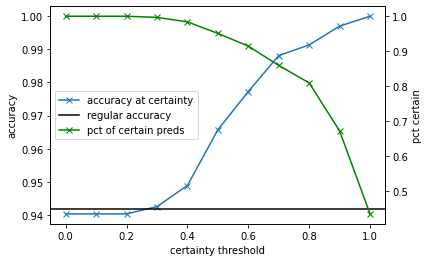

In [35]:
from jax_bayes.utils import entropy, certainty_acc

_batch = next(test_batches)

# evaluate the entropy of the posterior predictive
_batch = next(test_batches)
pp = posterior_predictive(params, _batch)
ent = jnp.mean(entropy(pp))
ent_upper_limit = float(entropy(jnp.ones((1,10))/10.))

# evaluate the accuracy and entropy
acc = accuracy(params, _batch)

print(f"acc = {acc:.4f}"
      f" | entropy = {ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

# plot how accuracy changes as we increase the required level of certainty
thresholds = [0.1 * i for i in range(11)] 
cert_accs, pct_certs = [], []
for t in thresholds:
  cert_acc, cert_mask = certainty_acc(pp, _batch['label'], cert_threshold=t)
  cert_accs.append(cert_acc)
  pct_certs.append(cert_mask.mean())

from matplotlib import pyplot as plt
f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This is similar to the MCMC case. Some remarks:
- the percent of 100% certain predictions is lower (40%) than the MCMC case (70%), so overall the model less certain
- however, the accuracy at 100% certain is still 100%
- we could probably improve this by training the model longer, but then it wouldn't be as fair a comparison
- one key difference is that we have O(P) number of parameters as the original model, whereas for MCMC we have O(n_samples * P) parameters, so the latter will always be more expressive

## Uncertainty Evaluation Out of Distribution

acc = 0.0969 | entropy = 1.2859 vs theoretical maximum 2.3026


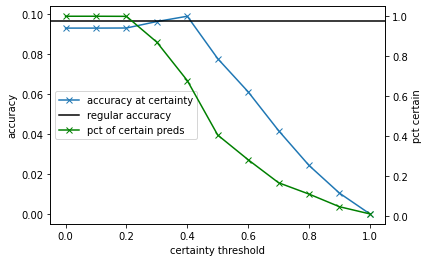

In [37]:
fashion_ds = tfds.load('fashion_mnist:3.*.*', split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))

fashion_batch = next(fashion_test_batches)
fa_pp = posterior_predictive(params, fashion_batch)
fa_acc = accuracy(params, fashion_batch)
fa_ent = jnp.mean(entropy(fa_pp))

print(f"acc = {fa_acc:.4f}"
      f" | entropy = {fa_ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

thresholds = [0.1 * i for i in range(11)] 
fa_cert_accs, fa_pct_certs = [], []
for t in thresholds:
  fa_cert_acc, fa_cert_mask = certainty_acc(fa_pp, fashion_batch['label'], cert_threshold=t)
  fa_cert_accs.append(fa_cert_acc)
  fa_pct_certs.append(fa_cert_mask.mean())

f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, fa_cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=fa_acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, fa_pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This is good! It's the same pattern we saw in the MCMC case --- the variational approximation to the posterior is able to correctly represent uncertainty on the out-of-distribution dataset.

## Conclusion: Bayesian Methods == Uncertainty